<a href="https://colab.research.google.com/gist/skyfallsin/7f11871fba50f2b50b5f361e4b43d114/ai-guide-evaluate-ml-results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How well is this model performing anyway?**

In the last section, we learned a lot about how to find the right metrics to evaluate a model's performance, and compare them apples to apples using published data.

The next step is to apply those metrics to your own use-case, driving a more quantitative approach to ML model usage.

First, let's import the same text back in as our training content and re-generate those summaries from the last section.

In [ ]:
import textwrap

content = """Mozilla's "Trustworthy AI" Thinking Points:

PRIVACY: How is data collected, stored, and shared? Our personal data powers everything from traffic maps to targeted advertising. Trustworthy AI should enable people to decide how their data is used and what decisions are made with it.

FAIRNESS: We’ve seen time and again how bias shows up in computational models, data, and frameworks behind automated decision making. The values and goals of a system should be power aware and seek to minimize harm. Further, AI systems that depend on human workers should protect people from exploitation and overwork.

TRUST: People should have agency and control over their data and algorithmic outputs, especially considering the high stakes for individuals and societies. For instance, when online recommendation systems push people towards extreme, misleading content, potentially misinforming or radicalizing them.

SAFETY: AI systems can carry high risk for exploitation by bad actors. Developers need to implement strong measures to protect our data and personal security. Further, excessive energy consumption and extraction of natural resources for computing and machine learning accelerates the climate crisis.

TRANSPARENCY: Automated decisions can have huge personal impacts, yet the reasons for decisions are often opaque. We need to mandate transparency so that we can fully understand these systems and their potential for harm."""

%pip install transformers sentencepiece

from transformers import set_seed
set_seed(248602)

In [ ]:
# Loading up Pegasus and BART again
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from transformers import BartTokenizer, BartForConditionalGeneration
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# summarizing using BART
set_seed(120986)
bart_model_name = "facebook/bart-large-cnn"

# Load the tokenizer
bart_tokenizer = BartTokenizer.from_pretrained(bart_model_name)

# Load the model
bart_model = BartForConditionalGeneration.from_pretrained(bart_model_name).to(device)

In [ ]:
# fetch BART summary
batch = bart_tokenizer(content, padding="longest", return_tensors="pt").to(device)
summarized = bart_model.generate(**batch, do_sample=True, top_p=0.5, top_k=50, max_new_tokens=500)
summarized_decoded = bart_tokenizer.batch_decode(summarized, skip_special_tokens=True)
bart_summarized_text = summarized_decoded[0]
print(bart_summarized_text)

Mozilla's "Trustworthy AI" Thinking Points: How is data collected, stored, and shared? Trustworthy AI should enable people to decide how their data is used. AI systems that depend on human workers should protect people from exploitation and overwork. The values and goals of a system should be power aware and seek to minimize harm.


In [ ]:
# summarizing using Pegasus

# We're using the version of Pegasus specifically trained for summarization
# using the CNN/DailyMail dataset
model_name = "google/pegasus-cnn_dailymail"

# Load the tokenizer
tokenizer = PegasusTokenizer.from_pretrained(model_name)

# Load the model
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

In [ ]:
# Tokenize the entire content
batch = tokenizer(content, padding="longest", return_tensors="pt").to(device)

# Generate the summary as tokens
summarized = model.generate(**batch)

# Decode the tokens back into text
summarized_decoded = tokenizer.batch_decode(summarized, skip_special_tokens=True)
pegasus_summarized_text = summarized_decoded[0]
print(pegasus_summarized_text)

Trustworthy AI should enable people to decide how their data is used.<n>values and goals of a system should be power aware and seek to minimize harm.<n>People should have agency and control over their data and algorithmic outputs.<n>Developers need to implement strong measures to protect our data and personal security.


Great. Now, how do you compare both of these models apples-to-apples in terms of summarization output? We're going to look at the familiar ROUGE-1 metric in more detail.

## Using a metric to evaluate model results

Typically, models are trained on larger datasets. Some fraction of the dataset is hidden from the model, and the evaluation is done by comparing the expected output from dataset with actual output from the model.

However, this doesn't work that well in our example. We usually will have a new bit of text that we're looking to get the best possible summary for.

So, we will need to build a small dataset to compare our task-specific performance. In this case, let's score using ROUGE-1 how closely our generated summaries match up to one a human would generate.

In [ ]:
# Let's create a human-powered reference:
reference = """
Mozilla's Trustworthy AI principles are Privacy controls over personal data,
minimizing bias and exploitation and maximizing Fairness,
ensuring data is sourced. and used appropriately leading to Trust,
Safety systems to protect from bad actors and environmental harm, and
Transparency to understand these systems in order to to reduce harm"""

Conveniently, Python actually has a ROUGE library that makes our computation easy.

In [ ]:
%pip install rouge

Next, we're going to dig into some specifics around how models are evaluated -- precision, recall and F-score. Let's start by comparing the two summarized texts with this reference by computing the ROUGE-1 score, then we'll dig into the pieces.


In [ ]:
from rouge import Rouge

rouge = Rouge()

# Now let's get the ROUGE scores
pegasus_scores = rouge.get_scores(pegasus_summarized_text, reference)[0]
bart_scores = rouge.get_scores(bart_summarized_text, reference)[0]

OK, now we have some actual numbers to look at.

First off, ROUGE is a metric that measures n-gram overlap. In 'n-gram' models and metrics, 'n' refers to the number of words. So:

*   **ROUGE-1**: n=1, unigram (single word)
*   **ROUGE-2**: n=2, bigram (word pairs)
*   **ROUGE-L**: measures overlap based on longest common subsequence (LCS) between generated and reference summaries

Each ROUGE score has three more components:

*  **Precision** (p): fraction of generated n-grams among reference summary
*  **Recall** (r): fraction of reference n-grams found in generated sumary
*  **F-Score** (f): harmonic mean of precision & recall, the final score

If a model has a ROUGE-1 score of 44, this means the f-score is 0.44, meaning 44% of the unigrams (single words) in the generated and compared summaries in the original datasets match the reference summary.

In [ ]:
# ROUGE-1 Scores
print(f"Pegasus ROUGE-1 Scores: {pegasus_scores['rouge-1']}")
print(f"BART ROUGE-1 Scores:    {bart_scores['rouge-1']}")
print()

Pegasus ROUGE-1 Scores: {'r': 0.275, 'p': 0.275, 'f': 0.2749999950000001}
BART ROUGE-1 Scores:    {'r': 0.325, 'p': 0.29545454545454547, 'f': 0.3095238045351475}



In [ ]:
# ROUGE-2 Scores
print(f"Pegasus ROUGE-2 Scores: {pegasus_scores['rouge-2']}")
print(f"BART ROUGE-2 Scores:    {bart_scores['rouge-2']}")
print()

Pegasus ROUGE-2 Scores: {'r': 0.0625, 'p': 0.061224489795918366, 'f': 0.06185566510362459}
BART ROUGE-2 Scores:    {'r': 0.0625, 'p': 0.05660377358490566, 'f': 0.05940593560631353}



In [ ]:
# ROUGE-L Scores
print(f"Pegasus ROUGE-L Scores: {pegasus_scores['rouge-l']}")
print(f"BART ROUGE-L Scores:    {bart_scores['rouge-l']}")
print()

Pegasus ROUGE-L Scores: {'r': 0.2, 'p': 0.2, 'f': 0.19999999500000015}
BART ROUGE-L Scores:    {'r': 0.3, 'p': 0.2727272727272727, 'f': 0.2857142807256236}



Now, even though both Pegasus & BART have reported ROUGE-1 scores of 40+, our scores here for the Mozilla Trustworthy AI human-generated summary are approximately:

* Pegasus: 27
* BART: 31

While this is below average, note that we now have a reasonable sense of quality based on our expectations.

This means we can iteratively make adjustments to our model text generation to get us closer to the average scores and beyond. But hold on... how do we know that ROUGE can't be easily gamed? Well, unfortunately for us, it *can*.

# Counter-Metrics & Why They Matter

ROUGE is an interesting metric in that it requires a human reference summary to compare against, and the final F-score is very closely tied to it.

Let's see what happens when we change the reference summary to something longer...

In [ ]:
reference = "Mozilla's 'Trustworthy AI' is built on five key principles. Privacy emphasizes user control over data collection and usage. Fairness focuses on minimizing bias in computational models, as well as protecting human workers from exploitation. Trust aims to provide individuals with control over their data and the decisions made by algorithms. Safety prioritizes protection against misuse of data, as well as reducing environmental impact. Lastly, Transparency mandates clarity in automated decision-making processes to prevent potential harm."
print(textwrap.fill(reference, 100))

Mozilla's 'Trustworthy AI' is built on five key principles. Privacy emphasizes user control over
data collection and usage. Fairness focuses on minimizing bias in computational models, as well as
protecting human workers from exploitation. Trust aims to provide individuals with control over
their data and the decisions made by algorithms. Safety prioritizes protection against misuse of
data, as well as reducing environmental impact. Lastly, Transparency mandates clarity in automated
decision-making processes to prevent potential harm.


Let's re-run the ROUGE scoring with this reference model...

In [ ]:
# Now let's get the ROUGE scores
pegasus_scores = rouge.get_scores(pegasus_summarized_text, reference)[0]
bart_scores = rouge.get_scores(bart_summarized_text, reference)[0]

# ROUGE-1 Scores
print(f"Pegasus ROUGE-1 Scores: {pegasus_scores['rouge-1']}")
print(f"BART ROUGE-1 Scores:    {bart_scores['rouge-1']}")
print()

# ROUGE-2 Scores
print(f"Pegasus ROUGE-2 Scores: {pegasus_scores['rouge-2']}")
print(f"BART ROUGE-2 Scores:    {bart_scores['rouge-2']}")
print()

# ROUGE-L Scores
print(f"Pegasus ROUGE-L Scores: {pegasus_scores['rouge-l']}")
print(f"BART ROUGE-L Scores:    {bart_scores['rouge-l']}")
print()

Pegasus ROUGE-1 Scores: {'r': 0.140625, 'p': 0.225, 'f': 0.1730769183431954}
BART ROUGE-1 Scores:    {'r': 0.203125, 'p': 0.29545454545454547, 'f': 0.24074073591220863}

Pegasus ROUGE-2 Scores: {'r': 0.056338028169014086, 'p': 0.08163265306122448, 'f': 0.06666666183472257}
BART ROUGE-2 Scores:    {'r': 0.04225352112676056, 'p': 0.05660377358490566, 'f': 0.04838709187955305}

Pegasus ROUGE-L Scores: {'r': 0.140625, 'p': 0.225, 'f': 0.1730769183431954}
BART ROUGE-L Scores:    {'r': 0.203125, 'p': 0.29545454545454547, 'f': 0.24074073591220863}



OK... that's now a huge drop in ROUGE-1 F-scores across both models, which is potentially problematic. The challenge here is that ROUGE doesn't capture the semantic meaning of the text to be summarized, it proxies using n-grams.

So, are there other metrics we can use to provide a more holistic picture? Yes, **meet BERTScore**.

# Using BERTScore for evaluating summary quality

BERTScore is a metric that uses contextual embeddings (in code, represented as matrix math, more on this later) to compare semantic similarities between the reference and generated summaries.

According to the [original paper](https://arxiv.org/abs/1904.09675), "BERTScore correlates better with human judgments and provides stronger model selection performance than existing metrics".

Unlike ROUGE, BERTScore actually generates results using BERT, another ML model, making it computationally more expensive. By default the [bert_score](https://github.com/Tiiiger/bert_score) library we're going to use will use the `roberta-large` BERT model downloaded from Huggingface.

Let's give this a shot.

In [ ]:
%pip install bert_score

In [ ]:
from bert_score import BERTScorer

# Let's setup BERTScorer and score the Pegasus set first
scorer = BERTScorer(lang="en", rescale_with_baseline=True)

In [ ]:
p, r, f1 = scorer.score([pegasus_summarized_text], [reference])
print(f"Pegasus BERTSCore: 'r': {r}, 'p': {p}, 'f': {f1}")

Pegasus BERTSCore: 'r': tensor([0.2065]), 'p': tensor([0.1569]), 'f': tensor([0.1829])


F1 value for BERTScore is 18 for Pegasus.

In [ ]:
p, r, f1 = scorer.score([bart_summarized_text], [reference])
print(f"BART BERTSCore: 'r': {r}, 'p': {p}, 'f': {f1}")

BART BERTSCore: 'r': tensor([0.2861]), 'p': tensor([0.3487]), 'f': tensor([0.3183])


Comparing apples-to-apples, the embedding-powered BERTScore reports F1 scores of 32 for the BART summary, which indicates that as per as this metric goes, BART is a better summary.

So, should we use ROUGE or BERTScore? The answer is - it's not that simple. Depending on your requirements, you should evaluate these and other metrics to decide whether a model is performing well for your use case.

What we can say is -- BERTScore may do a better job capturing meaning, and here are some visuals to help explain.

The `bert_score` library we are using allows us to map out how each word in a generated summary is scored against a reference to get a deeper sense of semantic understanding.

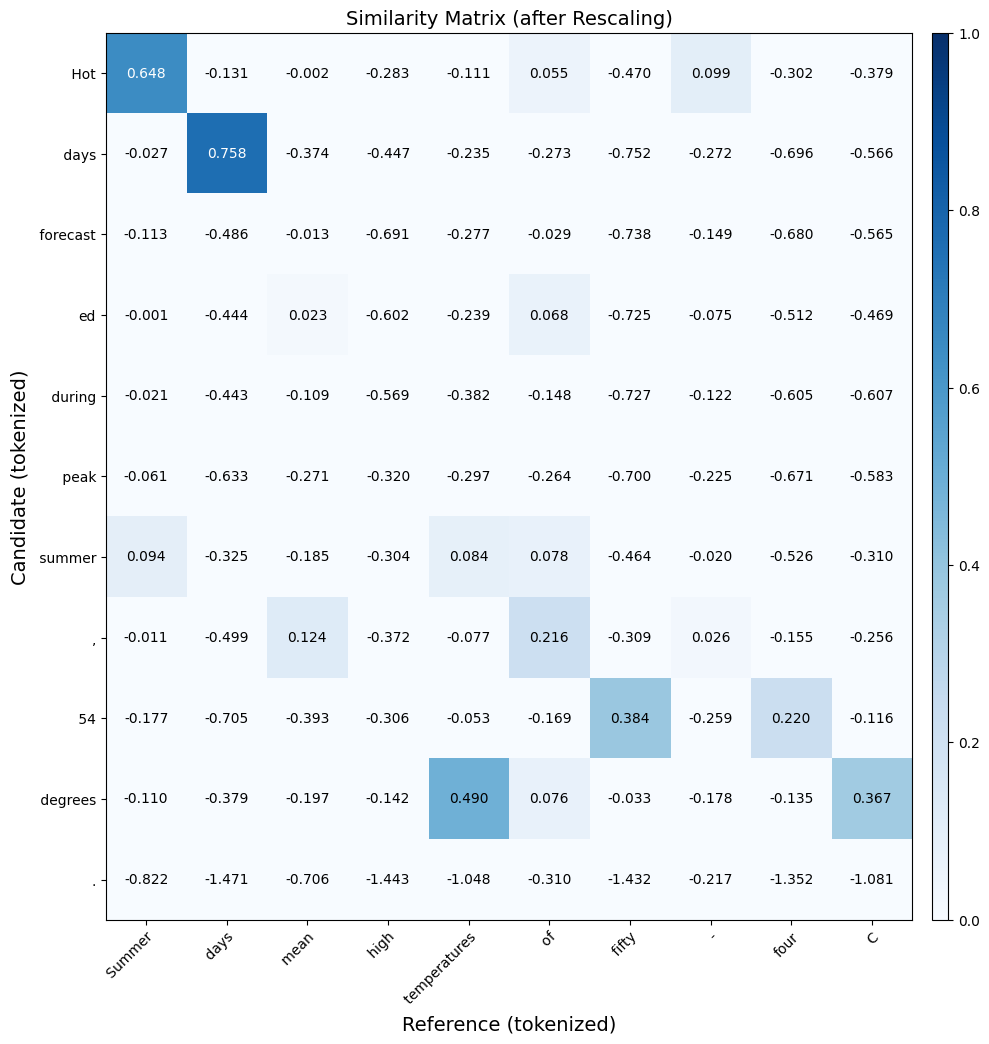

In [ ]:
# Let's use two NEW summary sentences to illustrate this effectively.
scorer.plot_example("Hot days forecasted during peak summer, 54 degrees.",
                    "Summer days mean high temperatures of fifty-four C")

Note the correlations between:

*   'summer' and 'hot'
*   'temperatures' and 'degrees'
*   'fifty' and '54' and
*   'C' and 'degrees'


There's one other metric that we will not be covering but is also well-suited for gauging semantic meaning - [QAEval](https://arxiv.org/abs/2010.00490), which uses a similar model-driven approach to scoring but also generates question/answer pairs to score against.


Using this foundation, in the next section focusing on Retrieval, we will be setting up a harness to store & retrieve documents, and monitor & evaluate the quality of our generative systems.